# The angle experiment plot

In [30]:
from system.controller.simulation.pybullet_environment import PybulletEnvironment, Robot
from system.controller.local_controller.local_navigation import vector_navigation
from system.controller.local_controller.local_controller import LocalController, controller_rules
import numpy as np
from system.types import Angle
import matplotlib.pyplot as plt
from system.plotting.plotHelper import environment_plot, add_environment
from system.tests.local_controller_angle_test import DirectionalCompass, WALL_CENTER

def angle_test(
    angle_: Angle,
    controller: LocalController,
    env: PybulletEnvironment,
) -> bool:
    angle = np.radians(angle_)
    goal_direction = np.array([-np.sin(angle), -np.cos(angle)])
    start = WALL_CENTER - 2*goal_direction
    compass = DirectionalCompass(angle, goal_offset=3, zero=WALL_CENTER)
    compass.reset_position(compass.zvalue(start))
    with Robot(env, base_position=start, base_orientation=-angle-np.radians(90)) as robot:
        success, _ = vector_navigation(env, compass, controller=controller)
        x, y = zip(*robot.data_collector.xy_coordinates)
        d = 100
    return x, y

controller = LocalController.default()
controller.on_reset_goal = [hook for hook in controller.on_reset_goal if type(hook) != controller_rules.TurnToGoal]

trajs = []
precision = 5
angles = [90 * (i / precision) for i in range(0, precision+1)]
with PybulletEnvironment(env_model="obstacle_map_2", visualize=False, contains_robot=False) as env:
    for angle in angles:
        trajs.append(angle_test(angle, controller, env))

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


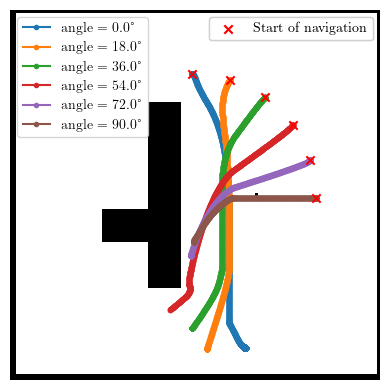

In [35]:
traj_plots = []

def add_trajectory(ax, x, y):
    global traj_plots
    traj_plots += ax.plot(x, y, marker='.')
    #ax.quiver(2*x[0] - x[d], 2*y[0] - y[d], x[d] - x[0], y[d] - y[0], width=0.01, zorder = 10)
    #ax.scatter([], [], marker=r'$\longrightarrow$', c="black", s=120, label="Start of navigation")

fig, ax = plt.subplots()
add_environment(ax, 'obstacle_map_2')

for x, y in trajs:
    add_trajectory(ax, x, y)

starts = np.array([[x[0], y[0]] for x, y in trajs])
start_plot = ax.scatter(starts[:, 0], starts[:, 1], c='r', marker='x', zorder=10)
ax.add_artist(plt.legend(traj_plots, [f'angle = {angle_}°' for angle_ in angles], loc='upper left'))
ax.add_artist(plt.legend([start_plot], ["Start of navigation"], loc='upper right'))
ax.axis('off')
fig.set_size_inches((4, 4))
fig.tight_layout()
plt.savefig('/tmp/obstacle_map_2.png')
plt.show()

In [24]:
traj_plots

[[<matplotlib.lines.Line2D at 0x7f63eec018b0>],

# Drawing a mouse in Matplotlib

In [70]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.path as mpath
from matplotlib.transforms import Affine2D

def add_mouse(ax, pos, *, angle=0, scale=1):
    Path = mpath.Path
    codes, verts = zip(*[
        (Path.MOVETO, [0, 0]),
        (Path.LINETO, [0.1, -0.1]),
        (Path.CURVE4, [1, -1]),
        (Path.CURVE4, [-1, -1]),
        (Path.CURVE4, [-0.1, -0.1]),
        (Path.CLOSEPOLY, [0, 0]),
    ])

    # Create a transformation
    transform = Affine2D().rotate(angle).scale(scale).translate(*pos)

    # Create the mouse path
    mouse_path = mpath.Path(verts, codes)
    mouse = mpatches.PathPatch(mouse_path, ec="black", fc="gray", transform=transform + ax.transData)

    # Add the mouse to the plot
    ax.add_patch(mouse)
    ax.update_datalim(verts)
    ax.autoscale_view()

# An image for map creation

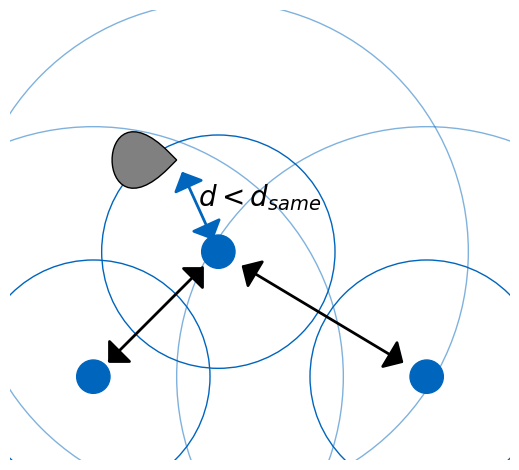

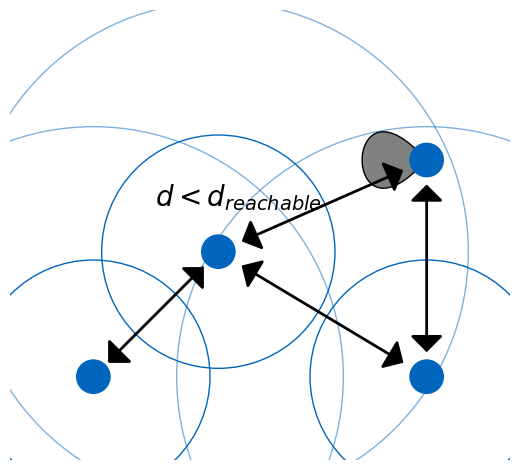

In [165]:
from system.plotting.plotHelper import TUM_colors

cells = [(-0.5, -0.5), (1.5, -0.5), (0.25, 0.25)]
def add_cells(ax):
    for cell in cells:
        ax.add_artist(mpatches.Circle(cell, radius=1.5, color=TUM_colors['TUMBlue'] + '80', fill=False))
        ax.add_artist(mpatches.Circle(cell, radius=0.7, color=TUM_colors['TUMBlue'], fill=False))
        ax.add_artist(mpatches.Circle(cell, radius=0.1, color=TUM_colors['TUMBlue']))
    add_arrow(cells[0], cells[2])
    add_arrow(cells[1], cells[2])

def add_arrow(frm, to, color='black', text=None, **text_kwargs):
    frm, to = np.array(frm), np.array(to)
    frm, to = 0.9*frm + 0.1*to, 0.1*frm + 0.9*to
    ax.add_artist(mpatches.FancyArrowPatch(
        frm, to,
        arrowstyle=mpatches.ArrowStyle('<|-|>', head_width=10, head_length=10), lw=2,
        color=color,
    ))
    if text is not None:
        ax.annotate(text, 0.5*(frm+to), fontsize=20, **text_kwargs)

fig, ax = plt.subplots()
ax.set_xlim([-1.0, 2.0])
ax.set_ylim([-1.0, 1.7])
ax.set_aspect('equal')
ax.axis('off')
fig.tight_layout()

pos = (0, 0.8)
angle = -np.radians(90)
speed = 1.5
add_cells(ax)
add_mouse(ax, pos=pos, angle=angle, scale=0.5)
#ax.arrow(*pos, -0.5*np.sin(angle), 0.5*np.cos(angle))
add_arrow(pos, cells[2], color=TUM_colors['TUMBlue'], text='$d < d_{same}$')
fig.savefig('/tmp/no_new_pc.pgf')

fig, ax = plt.subplots()
ax.set_xlim([-1.0, 2.0])
ax.set_ylim([-1.0, 1.7])
ax.set_aspect('equal')
ax.axis('off')
fig.tight_layout()

pos = (pos[0] - speed * np.sin(angle), pos[1] + speed * np.cos(angle))
add_cells(ax)
add_mouse(ax, pos=pos, angle=angle, scale=0.5)
ax.add_artist(mpatches.Circle(pos, radius=0.1, color=TUM_colors['TUMBlue']))
add_arrow(pos, cells[2], text='$d < d_{reachable}$', horizontalalignment='right')
add_arrow(pos, cells[1])
fig.savefig('/tmp/new_pc.pgf')